<a href="https://www.kaggle.com/code/shakthiraveen/anime-charactor-gen?scriptVersionId=197731549" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anime-faces/anime faces/cropped/34719_2011.jpg
/kaggle/input/anime-faces/anime faces/cropped/40266_2012.jpg
/kaggle/input/anime-faces/anime faces/cropped/40739_2013.jpg
/kaggle/input/anime-faces/anime faces/cropped/42515_2013.jpg
/kaggle/input/anime-faces/anime faces/cropped/36943_2012.jpg
/kaggle/input/anime-faces/anime faces/cropped/3388_2002.jpg
/kaggle/input/anime-faces/anime faces/cropped/51151_2015.jpg
/kaggle/input/anime-faces/anime faces/cropped/59579_2018.jpg
/kaggle/input/anime-faces/anime faces/cropped/36325_2012.jpg
/kaggle/input/anime-faces/anime faces/cropped/63045_2019.jpg
/kaggle/input/anime-faces/anime faces/cropped/43101_2013.jpg
/kaggle/input/anime-faces/anime faces/cropped/42450_2013.jpg
/kaggle/input/anime-faces/anime faces/cropped/45675_2014.jpg
/kaggle/input/anime-faces/anime faces/cropped/59070_2018.jpg
/kaggle/input/anime-faces/anime faces/cropped/32305_2011.jpg
/kaggle/input/anime-faces/anime faces/cropped/41147_2013.jpg
/kaggle/input/anime-faces

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os

In [29]:
image_dir='/kaggle/input/anime-faces/anime faces/cropped/'

In [30]:
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]

In [31]:
images[:2]

['/kaggle/input/anime-faces/anime faces/cropped/34719_2011.jpg',
 '/kaggle/input/anime-faces/anime faces/cropped/40266_2012.jpg']

## Data preprocessing

In [32]:
image_size = 64

In [33]:
def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image) # convert to jpeg
    image = tf.cast(image, tf.float32) # default in float64 -> to float32
    image = tf.image.resize(image, (image_size, image_size)) # resize the image
    image = image / 255.0 # normalize the image to scale 0-1
    image = tf.reshape(image, shape = (image_size, image_size, 3,)) # add the 3rd rgb dimention
    return image

In [34]:
batch_size = 128

#### Define the training dataset by slicing into batches to avoid memory out of bound error

In [35]:
training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

In [36]:
len(training_dataset)

241

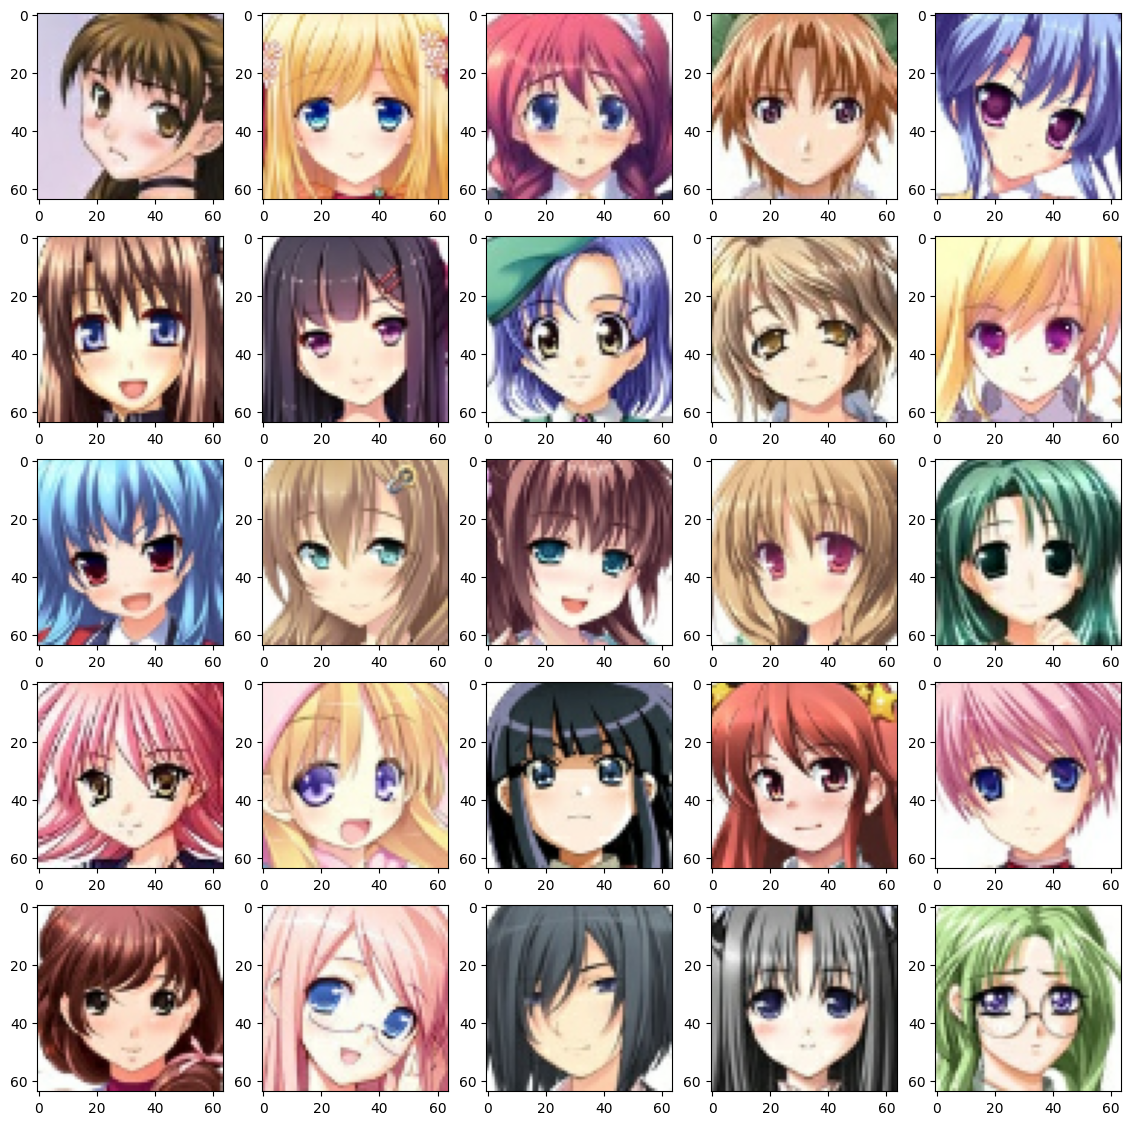

In [37]:
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

## Building the model

In [38]:
latent_dim = 512

In [39]:
from keras.models import Sequential, Model

from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation, LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam

from keras import backend as K

In [40]:
K.clear_session()

### Encoder

In [41]:
encoder_input = Input(shape = (64,64,3))

x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128,256,512]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

In [42]:
from keras.layers import Layer

# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

# Define a custom layer to encapsulate the TensorFlow operations
class SamplingLayer(Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.random.normal(shape=(tf.shape(mu)[0], tf.shape(mu)[1]))
        sigma = tf.exp(0.5 * log_var)
        z_eps = Multiply()([sigma, epsilon])
        z = Add()([mu, z_eps])
        return z

# Use the custom layer for sampling
z = SamplingLayer()([mu, log_var])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      2,432 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    204,928 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │    819,456 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  3,277,312 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  8,389,632 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    524,800 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_layer      │ (None, 512)       │          0 │ dense_1[0][0],    │
│ (SamplingLayer)     │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,802,688 (52.65 MB)

 Trainable params: 13,798,656 (52.64 MB)

 Non-trainable params: 4,032 (15.75 KB)

### Decoder

In [43]:
decoder = Sequential()
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8192)           │     8,396,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     3,277,056 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        51,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │         2,403 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,283,023 (50.67 MB)

 Trainable params: 13,280,009 (50.66 MB)

 Non-trainable params: 3,014 (11.77 KB)

### Loss function

vae loss = reconstruction loss + KL div

In [44]:
from keras.layers import Input
from keras.models import Model

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

class KLLossLayer(Layer): # Define a custom layer for KL Loss calculation
    def call(self, inputs):
        mu, log_var = inputs
        loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
        return loss

In [45]:
# Combine encoder and decoder using the Functional API
encoder_input = Input(shape=(64, 64, 3)) # Define the input layer
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)

# Create a KLLossLayer object
kl_loss_layer = KLLossLayer()
loss = kl_loss_layer([mu, log_var]) # Pass mu and log_var as a list

# Define the model with the loss included
model = Model(encoder_input, [reconstructed, loss], name ="vae")

In [46]:
model.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 512),     │ 13,802,688 │ input_layer_2[0]… │
│ (Functional)        │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64, 64, 3) │ 13,283,023 │ encoder[0][2]     │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kl_loss_layer       │ ()                │          0 │ encoder[0][0],    │
│ (KLLossLayer)       │                   │            │ encoder[0][1]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,085,711 (103.32 MB)

 Trainable params: 27,078,665 (103.30 MB)

 Non-trainable params: 7,046 (27.52 KB)

### Learning visualization

In [49]:
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "output/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

## Training model

In [51]:
from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 50

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [52]:
for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed, kl_loss = model(training_batch) # Unpack the output into reconstructed and kl_loss
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1]) # Reshape only the reconstructed output

            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())

            kl_losses.append(kl_loss.numpy()) # Use the unpacked kl_loss

            train_loss = 0.01 * kl_loss + mse_loss # Use the unpacked kl_loss

            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl_loss.numpy()))

Epoch:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.09873261 - KL loss: 0.00054000306
Epoch: 1 - Step: 1 - MSE loss: 0.09765395 - KL loss: 0.00046084222
Epoch: 1 - Step: 2 - MSE loss: 0.09389912 - KL loss: 0.0003918184
Epoch: 1 - Step: 3 - MSE loss: 0.09568765 - KL loss: 0.00030825555
Epoch: 1 - Step: 4 - MSE loss: 0.095401704 - KL loss: 0.00025604694
Epoch: 1 - Step: 5 - MSE loss: 0.09713787 - KL loss: 0.00021241728
Epoch: 1 - Step: 6 - MSE loss: 0.09364285 - KL loss: 0.0001690735
Epoch: 1 - Step: 7 - MSE loss: 0.095667474 - KL loss: 0.00014903216
Epoch: 1 - Step: 8 - MSE loss: 0.09450745 - KL loss: 0.00013151712
Epoch: 1 - Step: 9 - MSE loss: 0.09616813 - KL loss: 0.000112694725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch: 1 - Step: 10 - MSE loss: 0.09228704 - KL loss: 9.5647716e-05
Epoch: 1 - Step: 11 - MSE loss: 0.09471489 - KL loss: 9.189756e-05
Epoch: 1 - Step: 12 - MSE loss: 0.09220656 - KL loss: 8.849713e-05
Epoch: 1 - Step: 13 - MSE loss: 0.0909913

## Visualize the outpouts

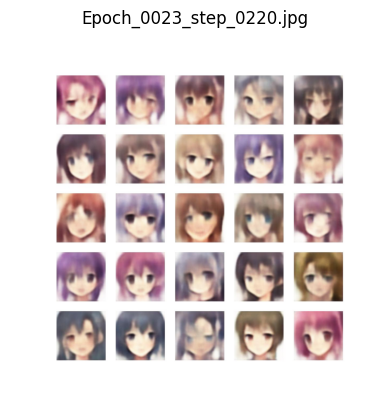

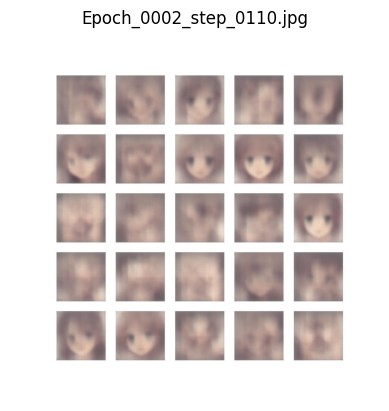

In [ ]:
import cv2

output_dir = "output/"
files = os.listdir(output_dir)

for file in files:
    image = cv2.imread(output_dir + file)
    
    # Convert the image from BGR (OpenCV format) to RGB (matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image using matplotlib
    plt.imshow(image_rgb)
    plt.title(file)  # Optional: display the file name as title
    plt.axis('off')  # Turn off the axis
    plt.show()

In [54]:
import cv2
output_dir = "output/"
files = os.listdir(output_dir)

for file in files:
    image = cv2.imread(output_dir + file)
    cv2.imshow("Output", image)
    if cv2.waitKey(1) and 0xFF == ord('q'):
        break

error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
